# Pittsburgh Neighborhoods by Crime Rate

![cop car](https://media.giphy.com/media/l4pTdvQhGedNxG4JG/giphy.gif)

Data Source: https://data.wprdc.org/dataset/arrest-data

In [2]:
import pandas as pd
import numpy as np
import geopandas

## Introduction

To find the best neighhborhood in Pittsburgh, we will analyze the Pittsburgh Police Arrest dataset from the Western Pennsylvania Regional Data Center. Listed below is the dictionary for the less inuitive columns in the data set .

In [3]:
data_dictionary = {
    "PK": "Unique identifier for each arrest incident",
    "CCR": "Incident Number",
    "X": "The geocoded X coordinate of the incident location",
    "Y": "The geocoded Y coordinate of the incident location"
}
dictionary = pd.Series(data=data_dictionary, index=['PK', 'CCR', 'X', 'Y'])
print(dictionary)

PK            Unique identifier for each arrest incident
CCR                                      Incident Number
X      The geocoded X coordinate of the incident loca...
Y      The geocoded Y coordinate of the incident loca...
dtype: object


In [4]:
data = pd.read_csv("ArrestData.csv", index_col="_id")
data.head(10)

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
_id,,,,,,,,,,,,,,,,
1,1975272,16158872,42.0,F,B,2016-08-24T12:20:00,"4700 Block Centre AV Pittsburgh, PA 15213",3929 Retail Theft.,"4700 Block Centre AV Pittsburgh, PA 15213",Bloomfield,5,804.0,8.0,2.0,-79.949277,40.452551
2,1974456,16144120,31.0,M,W,2016-08-03T14:55:00,"4200 Block Steubenville PKE Pittsburgh, PA 15205",13(a)(16) Possession of Controlled Substance,"4200 Block Steubenville PKE Pittsburgh, PA 15205",Outside City,OSC,5599.0,NaN,NaN,-80.088018,40.440136
3,1974466,16144165,63.0,F,B,2016-08-03T16:45:00,"900 Block Freeport RD Fox Chapel, PA 15238",3929 Retail Theft.,"900 Block Freeport RD Fox Chapel, PA 15238",Westwood,5,2811.0,9.0,2.0,-79.891803,40.486625
4,1974550,16145257,25.0,F,W,2016-08-05T02:36:00,"Foreland ST & Cedar AV Pittsburgh, PA 15212",5503 Disorderly Conduct. / 5505 Public Drunken...,"Foreland ST & Cedar AV Pittsburgh, PA 15212",East Allegheny,1,2304.0,1.0,1.0,-80.001939,40.454080
5,1974596,16145962,25.0,M,B,2016-08-06T02:00:00,"900 Block Woodlow ST Pittsburgh, PA 15205",2702 Aggravated Assault. / 2705 Recklessy Enda...,"900 Block Woodlow ST Pittsburgh, PA 15205",Crafton Heights,5,2814.0,2.0,5.0,-80.052204,40.445900
6,1974556,16144301,45.0,M,W,2016-08-15T13:30:00,"600 Block 1st AV Pittsburgh, PA 15219",3929 Retail Theft.,"800 Block Hazelwood AV Pittsburgh, PA 15217",Greenfield,4,1517.0,5.0,3.0,-79.929238,40.419699
7,1974628,16147655,29.0,M,W,2016-08-16T13:00:00,"2300 Block Pioneer AV Pittsburgh, PA 15226",2701 Simple Assault.,"2300 Block Pioneer AV Pittsburgh, PA 15226",Brookline,6,1919.0,4.0,5.0,-80.020357,40.400037
8,1974607,16146037,21.0,F,B,2016-08-16T04:25:00,"600 Block 1st AV Pittsburgh, PA 15219",2701 Simple Assault. / 5505 Public Drunkenness...,"700 Block S Braddock AV Pittsburgh, PA 15221",Regent Square,4,1410.0,NaN,NaN,-79.834462,40.398957
9,1974643,16132537,17.0,M,B,2016-08-29T17:55:00,"1400 Block Washington BL Pittsburgh, PA 15206",903 Criminal Conspiracy. / 3701 Robbery.,"N Euclid AV & Broad ST Pittsburgh, PA 15206",East Liberty,5,1115.0,NaN,NaN,NaN,NaN


Looking at the first 10 rows of the dataset, we can see the available data about arrests in Pittsburgh by including the location, age/race of suspect, gender, severity of of the crime, and more. For the purpose of ranking neighborhoods by number of arrests, factors such as age, gender, and race are not relevant. Instead, we are interested in the total number of arrests per Pittsburgh neighborhood.

In [5]:
neighborhood_df = data.filter(['INCIDENTNEIGHBORHOOD'], axis=1)
#alternative ways of creating data frame:
#neighborhood_df = data.loc[:, "INCIDENTNEIGHBORHOOD"]
#neighborhood_df = pd.DataFrame([data.INCIDENTNEIGHBORHOOD]).transpose()
print(neighborhood_df.head(20))

    INCIDENTNEIGHBORHOOD
_id                     
1             Bloomfield
2           Outside City
3               Westwood
4         East Allegheny
5        Crafton Heights
6             Greenfield
7              Brookline
8          Regent Square
9           East Liberty
10                   NaN
11            East Hills
12               Carrick
13        East Allegheny
14       Crafton Heights
15        East Allegheny
16      Allegheny Center
17        East Allegheny
18      South Side Flats
19             Brookline
20              Sheraden


Creating a dataframe with only the incident neighborhood and offense committed, we are able to have a better understanding how many times a neighbhorhood appears in a reported arrest. Now we want to clean up our data a bit to see how many unique values there are or if any values are missing

In [6]:
#lets tidy up the data a bit and dive deeper
#rename column to something easier to type
neighborhood_df = neighborhood_df.rename(columns={'INCIDENTNEIGHBORHOOD': 'NEIGHBORHOODS'})
#remove all null values in data
neighborhood_df = neighborhood_df.dropna()
#see how many distinct neighborhoods exists in data set
neighborhood_df['NEIGHBORHOODS'].unique()
#98 neighborhoods

array(['Bloomfield', 'Outside City', 'Westwood', 'East Allegheny',
       'Crafton Heights', 'Greenfield', 'Brookline', 'Regent Square',
       'East Liberty', 'East Hills', 'Carrick', 'Allegheny Center',
       'South Side Flats', 'Sheraden', 'East Carnegie',
       'Golden Triangle/Civic Arena', 'Point Breeze North', 'Perry South',
       'Allentown', 'North Shore', 'Marshall-Shadeland',
       'Central Oakland', 'Middle Hill', 'Strip District',
       'Lincoln-Lemington-Belmar', 'Central Northside',
       'Troy Hill-Herrs Island', 'Highland Park', 'Homewood North',
       'Northview Heights', 'Brighton Heights', 'Hazelwood',
       'Perry North', 'Bedford Dwellings', 'Elliott', 'Beechview',
       'Fineview', 'Glen Hazel', 'Spring Hill-City View', 'Bluff',
       'Manchester', 'Homewood West', 'Outside County', 'Point Breeze',
       'Homewood South', 'Squirrel Hill South', 'Terrace Village',
       'Upper Lawrenceville', 'Arlington', 'South Side Slopes',
       'Lower Lawrencevill

In [7]:
##Create loop to track how many arrests per neighborhood
arrests_count = dict()
for row in neighborhood_df['NEIGHBORHOODS']:
    neighborhood = row[0:]
    if neighborhood not in arrests_count:
        arrests_count[neighborhood] = 1
    else:
        arrests_count[neighborhood] += 1
arrests_count

{'Bloomfield': 929,
 'Outside City': 298,
 'Westwood': 209,
 'East Allegheny': 2008,
 'Crafton Heights': 545,
 'Greenfield': 496,
 'Brookline': 1266,
 'Regent Square': 35,
 'East Liberty': 1733,
 'East Hills': 1083,
 'Carrick': 2198,
 'Allegheny Center': 1180,
 'South Side Flats': 3185,
 'Sheraden': 1191,
 'East Carnegie': 48,
 'Golden Triangle/Civic Arena': 83,
 'Point Breeze North': 260,
 'Perry South': 989,
 'Allentown': 884,
 'North Shore': 757,
 'Marshall-Shadeland': 1402,
 'Central Oakland': 487,
 'Middle Hill': 880,
 'Strip District': 471,
 'Lincoln-Lemington-Belmar': 1216,
 'Central Northside': 23,
 'Troy Hill-Herrs Island': 6,
 'Highland Park': 529,
 'Homewood North': 1837,
 'Northview Heights': 661,
 'Brighton Heights': 1024,
 'Hazelwood': 1287,
 'Perry North': 567,
 'Bedford Dwellings': 616,
 'Elliott': 619,
 'Beechview': 1115,
 'Fineview': 773,
 'Glen Hazel': 153,
 'Spring Hill-City View': 667,
 'Bluff': 1370,
 'Manchester': 445,
 'Homewood West': 731,
 'Outside County': 52

In [8]:
#lets verify that our loop works:
print(neighborhood_df['NEIGHBORHOODS'].value_counts()['Bloomfield'])
print(neighborhood_df['NEIGHBORHOODS'].value_counts()['Outside City'])
print(neighborhood_df['NEIGHBORHOODS'].value_counts()['Westwood'])
print(neighborhood_df['NEIGHBORHOODS'].value_counts()['Esplen'])
print(neighborhood_df['NEIGHBORHOODS'].value_counts()['East Liberty'])
print(neighborhood_df['NEIGHBORHOODS'].value_counts()['Hays'])

929
298
209
191
1733
106


Now that our data in the dictionary has been verified, lets create a dataframe using the information above to see the neighborhoods with the highest rates of arrest

In [9]:
arrests_df = pd.DataFrame.from_dict(arrests_count, orient='index')
#We want to sort the data from greatest to least
arrests_df = arrests_df[0].sort_values(ascending=False)

Using the head() and tail() functions, we can see the top 10 neighborhoods with the highest and lowest reports of arrests

In [10]:
print(arrests_df.head(10))

Central Business District    3782
South Side Flats             3185
Carrick                      2198
East Allegheny               2008
Homewood South               1939
Homewood North               1837
East Liberty                 1733
Marshall-Shadeland           1402
Bluff                        1370
Mount Washington             1353
Name: 0, dtype: int64


In [11]:
print(arrests_df.tail(10))

East Carnegie              48
Swisshelm Park             40
Chartiers City             40
New Homestead              39
Regent Square              35
Ridgemont                  35
Central Northside          23
Mt. Oliver Boro            18
Troy Hill-Herrs Island      6
Mt. Oliver Neighborhood     2
Name: 0, dtype: int64


## Visualizing our data

In [12]:
lowArrest = pd.DataFrame(arrests_df.tail(10))
lowArrest.columns = ['arrests']
print(lowArrest)

                         arrests
East Carnegie                 48
Swisshelm Park                40
Chartiers City                40
New Homestead                 39
Regent Square                 35
Ridgemont                     35
Central Northside             23
Mt. Oliver Boro               18
Troy Hill-Herrs Island         6
Mt. Oliver Neighborhood        2


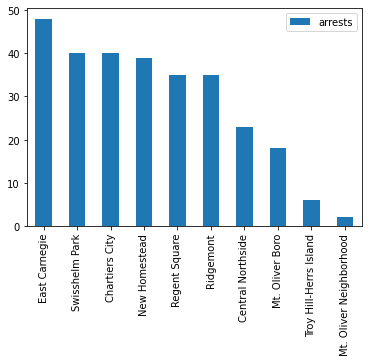

In [13]:
lowArrest.plot(kind='bar')

### Given the data, Mt. Oliver Neighborhood may be considered the best by our metric since it has the lowest number of reported arrests within the arrest data set. ###